In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
import polars as pl

from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

from dataclasses import dataclass
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()
sys.path.append(f'/home/{user_name}/Documents/cernbox/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *

plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True
                     })

In [2]:
# with uproot.open('/home/pgranger/atmospherics/sum_50k_hd_AV.root') as f:
file = '/home/henrique/Documents/cernbox/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/flatcaf_sum.root'
def loadData(file):
    with uproot.open(file) as f:
        tree = f['cafTree']
        tree.show()
        cols = [key for key in tree.keys() if "Jagged" not in str(tree[key].interpretation)]

        data = f['cafTree'].arrays(cols, library='np')
        df = pl.from_pandas(pd.DataFrame(data))
        return df
    # print(df)

# df = loadData(file)
# dfold = loadData('/home/henrique/Documents/cernbox/Atmos_Pandora/data/atm_50k_hd_AV/caf_sum.root')
# dfnew = loadData('/home/henrique/Documents/cernbox/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/flatcaf_sum_300k_new2.root')
dfnew = pl.read_parquet('/home/henrique/Documents/cernbox/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/flatcaf_sum_300k_new2.parquet')

In [8]:
dfnew.filter(pl.col('rec.RecoMethodNumu')==3).select('rec.Ev_reco_numu').describe()

In [13]:
pl.Config.set_tbl_rows(20)
@dataclass
class Flavour:
    pdg:int
    name:str
    name_latex:str
    cvn:str

flavours = {
    -16: Flavour(-16, "nutaubar", r"$\overline{\nu}_\tau$", "rec.cvnnutau"),
    -14: Flavour(-14, "numubar", r"$\overline{\nu}_\mu$", "rec.cvnnumu"),
    -12 : Flavour(-12, "nuebar", r"$\overline{\nu}_e$", "rec.cvnnue"),
    12: Flavour(12, "nue", r"$\nu_e$", "rec.cvnnue"),
    14: Flavour(14, "numu", r"$\nu_\mu$", "rec.cvnnumu"),
    16: Flavour(16, "nutau", r"$\nu_\tau$", "rec.cvnnutau")
}

def get_max():
    return  pl.max('rec.cvnnue','rec.cvnnumu','rec.cvnnutau','rec.cvnnc')

def define_flavour(df:pl.DataFrame):
    df = df.with_columns(
        Flavour = pl.when(get_max()==None).then(0).otherwise(
        pl.when((pl.col('rec.cvnnue') >= 0.5)).then(12).otherwise(
        pl.when(pl.col('rec.cvnnumu')>=0.5).then(14).otherwise(
        pl.when(pl.col('rec.cvnnc')>=0.5).then(0).otherwise(16)
        )))
    )
    return df

def fill_empty_categories(df, labels):

    empty_result = pl.DataFrame({ col: [0. for _ in labels] for col in df.columns })
    empty_result.with_columns(pl.Series(name='Ecut', values=labels))

    # works, but need to add manually.
    # empty_result = pl.DataFrame({'purity': 0., 'completeness': 0., 'total_events':0., 'Ecut': labels})
    empty_result = empty_result.with_columns(Ecut=pl.col('Ecut').cast(pl.Int16))

    out = pl.concat([empty_result,df],how='diagonal')
    out = out.groupby('Ecut').agg(
        pl.all().sum()
        # purity = pl.col("purity").sum(),
        # completeness = pl.col("completeness").sum(),
    ).sort('Ecut')
    return out

def eval_err(var:str):
    return pl.when(pl.col(var)!=0).then(1./pl.col(var).sqrt()).otherwise(1)

def eval_err_div(f:str, x:str, y:str, errx:str, erry:str):
    return pl.when(pl.col(x)!=0).then((pl.col(f)/pl.col(x)).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(
        pl.when(pl.col(y)>1).then((1./(pl.col(x) + pl.col(y))).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(0.)
    )

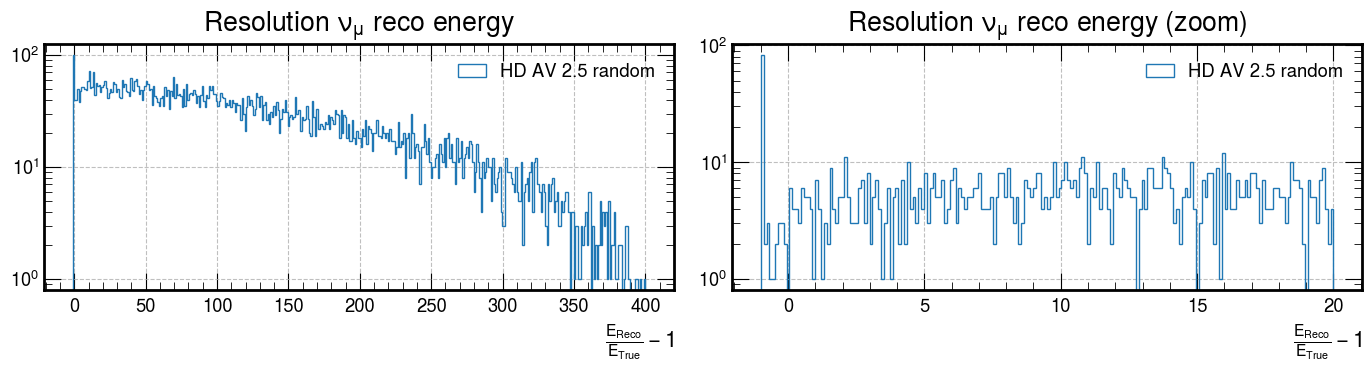

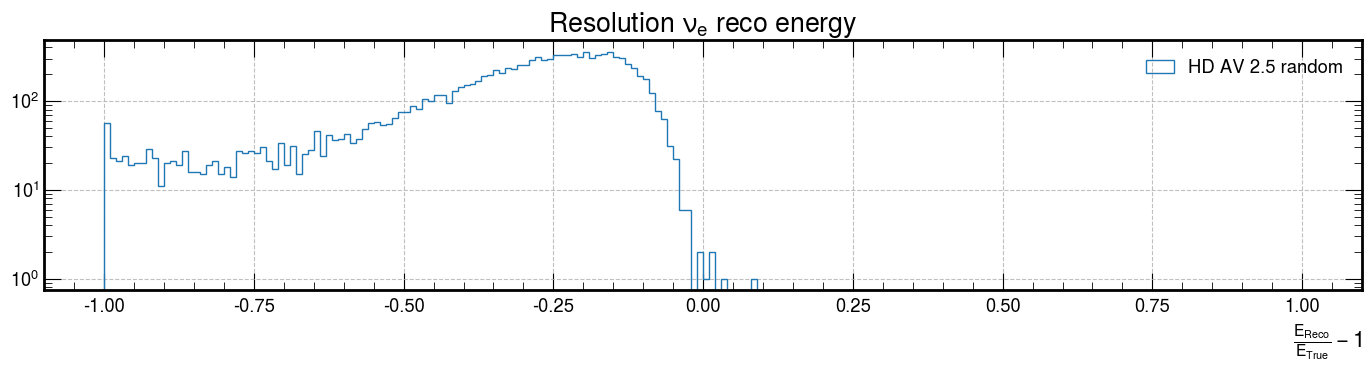

In [10]:
len_cm = [9.833E-1, 1.786E0, 3.321E0, 6.598E0, 1.058E1,
          3.084E1, 4.250E1, 6.732E1, 1.063E2, 1.725E2,
          2.385E2, 4.934E2, 6.163E2, 8.552E2, 1.202E3,
          1.758E3, 2.297E3, 4.359E3, 5.354E3, 7.298E3, 1.013E4, 1.469E4, 1.910E4, 3.558E4, 4.326E4, 5.768E4, 7.734E4, 1.060E5, 1.307E5]
 
KE_MeV = [10, 14, 20, 30, 40, 80, 100, 140, 200, 300, 400, 800, 1000, 1400, 2000, 3000,
          4000, 8000, 10000, 14000, 20000, 30000, 40000, 80000, 100000, 140000,
          200000, 300000, 400000]
from scipy.interpolate import CubicSpline
spl = CubicSpline(len_cm,KE_MeV)

def flavour(pdg):
    return pl.col('rec.nuPDG') == pdg
    # return pl.col('Flavour') == pdg

def energy(pdg):
    En = 'Ev'
    # return (pl.col(En) >=1 ) & (pl.col(En) <= 10)
    return (pl.col(En) >=0 )
def checkEnergy(df):
    E = df.with_columns(
        lep_range_cm = (pl.col('rec.RecoLepEnNumu').pow(2) - 0.105*0.105).sqrt()

    ).with_columns(
        Ev = pl.col('rec.Ev'),
        Ev_reco = pl.col('rec.Ev_reco'),
        Ev_reco_nue = pl.col('rec.Ev_reco_nue'),
        Ev_reco_numu = pl.col('rec.Ev_reco_numu'),
        Ev_reco_numu_h = ((pl.col('lep_range_cm').apply(lambda x: spl(x)/1000).pow(2) + 0.105*0.105)).sqrt()+pl.col('rec.RecoHadEnNumu'),
        LepE_h = ((pl.col('lep_range_cm').apply(lambda x: spl(x)/1000).pow(2) + 0.105*0.105)).sqrt()
    ).with_columns(
        Eres = pl.col("Ev_reco")/pl.col("Ev") - 1,
        Eres_nue = pl.col("Ev_reco_nue")/pl.col("Ev") - 1,
        Eres_numu = pl.col("Ev_reco_numu")/pl.col("Ev") - 1,
        Eres_numu_h = pl.col("Ev_reco_numu_h")/pl.col("Ev") - 1,
    )
    return E
E = checkEnergy(df)
Eold = checkEnergy(dfold)
fig, axs = plt.subplots(1,2,figsize=(14,4))
binsmu = 400
binsmu_z = 200
binse = 200

limmu = 400
limmu_z = 20
lime = 1
ax = axs[0]
ax.hist(E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=binsmu, range=(-1,limmu), log=True, histtype='step', label='HD AV 2.5 random');
# ax.hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=400, range=(-1,limmu), log=True, histtype='step', label='HD AV');
ax.set_title(r'Resolution $\nu_\mu$ reco energy')
ax.set_xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
ax.legend()
ax = axs[1]
ax.hist(E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=binsmu_z, range=(-1,limmu_z), log=True, histtype='step', label='HD AV 2.5 random');
# ax.hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=200, range=(-1,limmu_z), log=True, histtype='step', label='HD AV');
ax.set_title(r'Resolution $\nu_\mu$ reco energy (zoom)')
ax.set_xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
ax.legend()
plt.figure(figsize=(14,4))
plt.hist(E.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))['Eres_nue'], bins=binse, range=(-1, lime),log=True, histtype='step', label='HD AV 2.5 random');
# plt.hist(Eold.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))['Eres_nue'], bins=200, range=(-1, lime),log=True, histtype='step', label='HD AV');
plt.title(r'Resolution $\nu_e$ reco energy')
plt.xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
plt.legend()

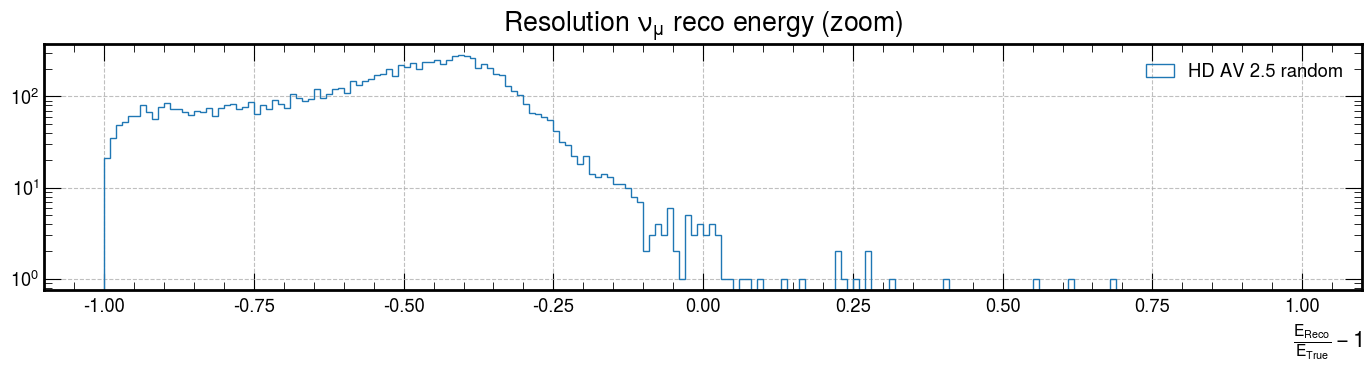

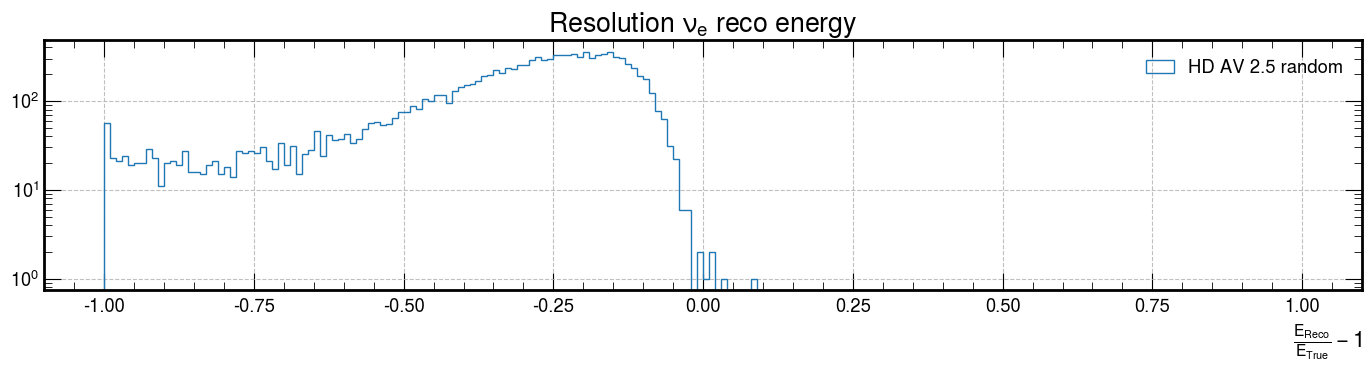

In [14]:
fig, axs = plt.subplots(1,1,figsize=(14,4))
binsmu_z = 200
binse = 200

limmu_z = 1
lime = 1
ax = axs
ax.hist(E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu_h'], bins=binsmu_z, range=(-1,limmu_z), log=True, histtype='step', label='HD AV 2.5 random');
# ax.hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=200, range=(-1,limmu_z), log=True, histtype='step', label='HD AV');
ax.set_title(r'Resolution $\nu_\mu$ reco energy (zoom)')
ax.set_xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
ax.legend()
plt.figure(figsize=(14,4))
plt.hist(E.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))['Eres_nue'], bins=binse, range=(-1, lime),log=True, histtype='step', label='HD AV 2.5 random');
# plt.hist(Eold.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))['Eres_nue'], bins=200, range=(-1, lime),log=True, histtype='step', label='HD AV');
plt.title(r'Resolution $\nu_e$ reco energy')
plt.xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
plt.legend()

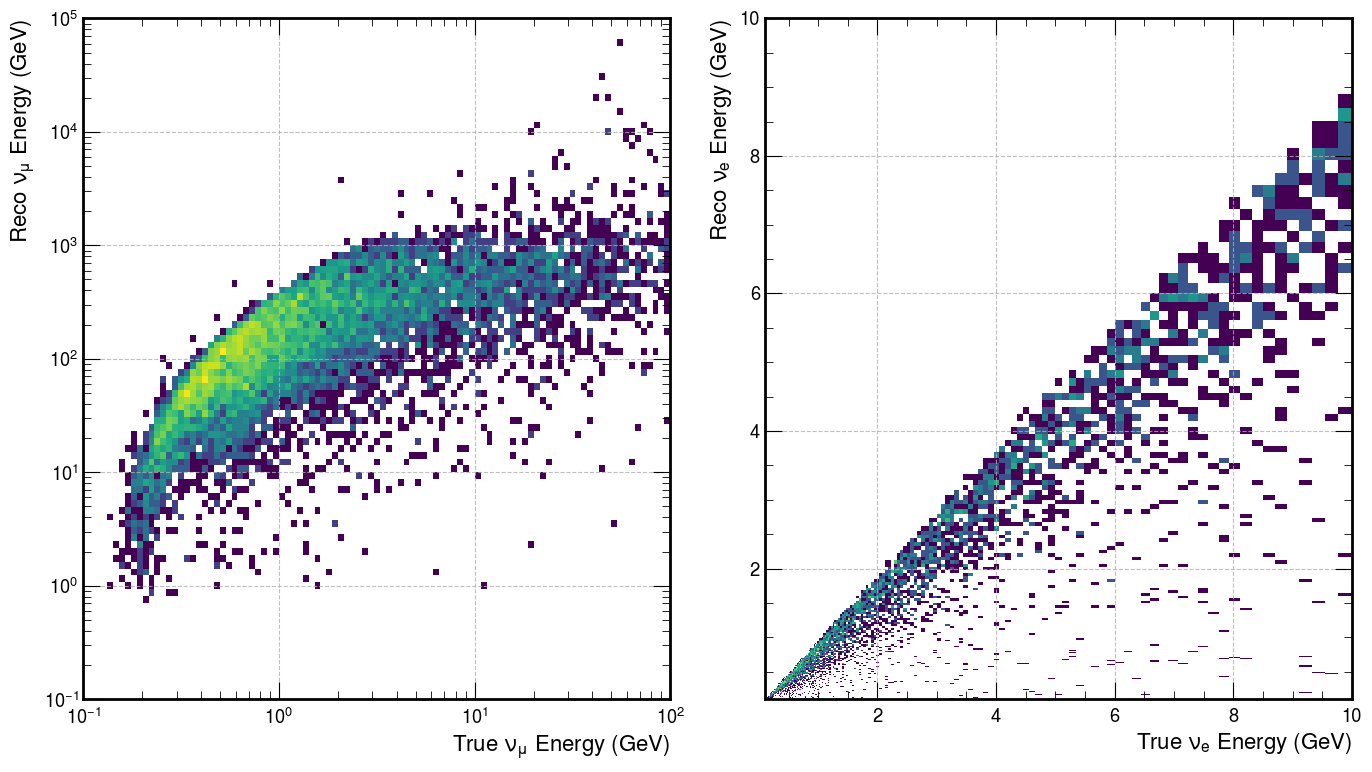

In [15]:
E = checkEnergy(df)
Eold = checkEnergy(dfold)
Emu = E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))
Ee = E.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))
ax:plt.Axes
binsx = np.logspace(-1,np.log10(100),100)
binsy = np.logspace(-1,np.log10(1e5),100)
# binsx = np.linspace(0.1,20,200)
# binsy = np.linspace(0.1,20,200)
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].hist2d(Emu['Ev'], Emu['Ev_reco_numu'], bins=(binsx,binsy), range=((0,10),(0,10)), norm = LogNorm())
ax[0].set_xlabel(rf'True {flavours[14].name_latex} Energy (GeV)')
ax[0].set_ylabel(rf'Reco {flavours[14].name_latex} Energy (GeV)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
binsx = np.logspace(-1,np.log10(10),200)
binsy = np.logspace(-1,np.log10(10),200)
ax[1].hist2d(Ee['Ev'], Ee['Ev_reco_nue'], bins=(binsx, binsy), norm = LogNorm());
ax[1].set_xlabel(rf'True {flavours[12].name_latex} Energy (GeV)')
ax[1].set_ylabel(rf'Reco {flavours[12].name_latex} Energy (GeV)')
plt.show()

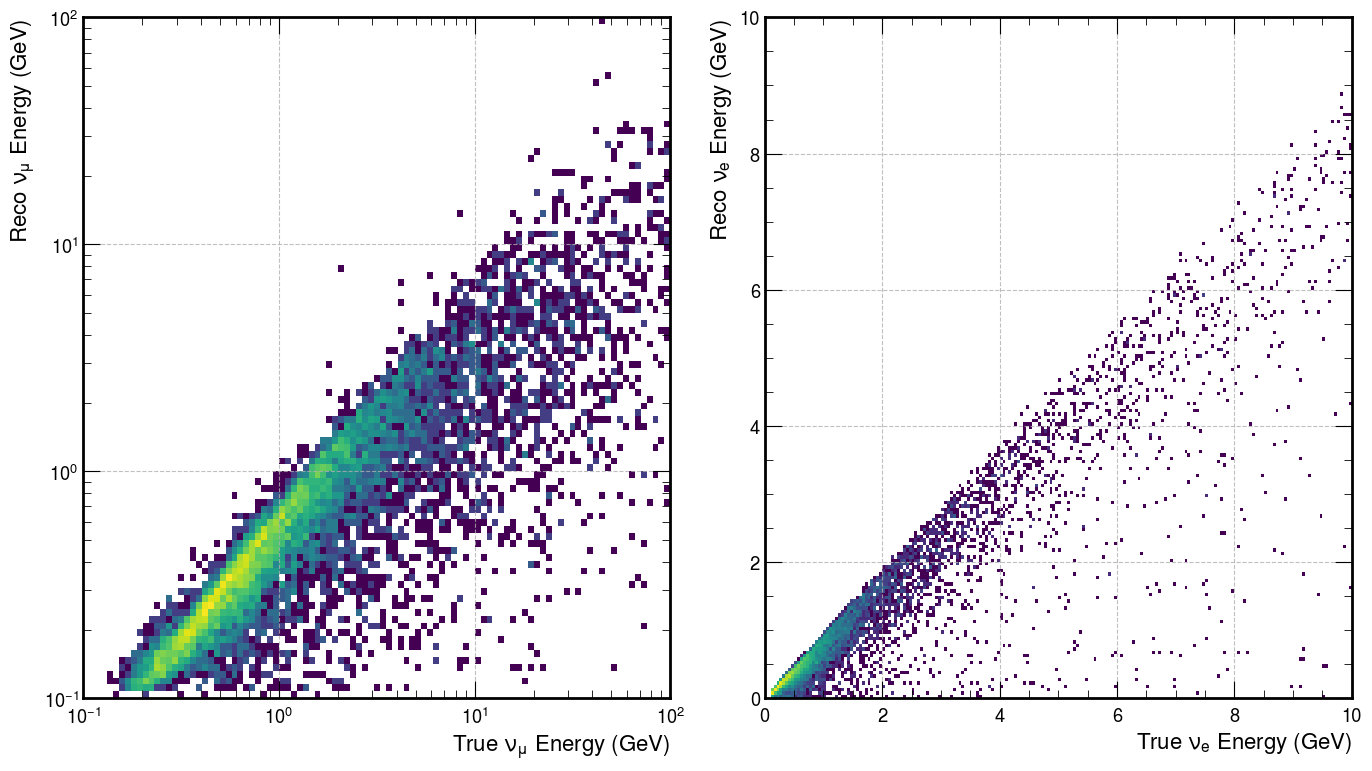

In [16]:

E = checkEnergy(df)
Eold = checkEnergy(dfold)
Emu = E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14)).filter(pl.col('rec.LongestTrackContNumu') != -1)
Ee = E.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))
ax:plt.Axes
binsx = np.logspace(-1,np.log10(100),100)
binsy = np.logspace(-1,np.log10(100),100)
# binsx = np.linspace(-1,20,200)
# binsy = np.linspace(-1,20,200)
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].hist2d(Emu['Ev'], Emu['Ev_reco_numu_h'], bins=(binsx,binsy), range=((0,10),(0,10)), norm = LogNorm())
ax[0].set_xlabel(rf'True {flavours[14].name_latex} Energy (GeV)')
ax[0].set_ylabel(rf'Reco {flavours[14].name_latex} Energy (GeV)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].hist2d(Ee['Ev'], Ee['Ev_reco_nue'], bins=(200,200), range=((0,10),(0,10)), norm = LogNorm());
ax[1].set_xlabel(rf'True {flavours[12].name_latex} Energy (GeV)')
ax[1].set_ylabel(rf'Reco {flavours[12].name_latex} Energy (GeV)')
plt.show()

In [95]:
Enew.filter(pl.col('rec.RecoMethodNumu')==3)['rec.RecoMethodNue'].describe()

statistic,value
str,f64
"""count""",80167.0
"""null_count""",0.0
"""mean""",2.293999
"""std""",0.455594
"""min""",2.0
"""max""",3.0
"""median""",2.0
"""25%""",2.0
"""75%""",3.0


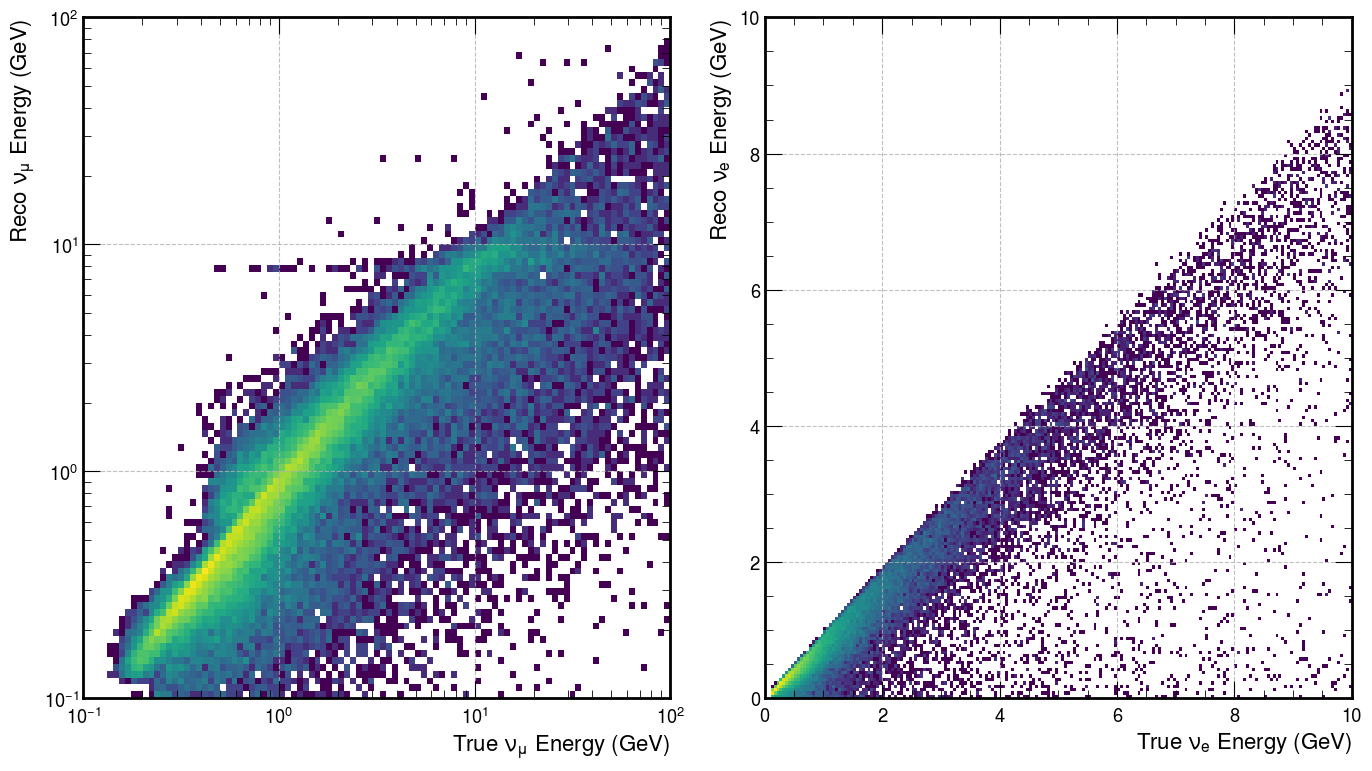

In [31]:
Enew = dfnew
Emu = Enew.filter(flavour(14)).filter(pl.col('rec.isCC')==1)#.filter(energy(14))#.filter(pl.col('rec.LongestTrackContNumu') != -1)
Ee = Enew.filter(flavour(12)).filter(pl.col('rec.isCC')==1)#.filter(energy(12))
ax:plt.Axes
binsx = np.logspace(-1,np.log10(100),100)
binsy = np.logspace(-1,np.log10(100),100)
# binsx = np.linspace(-1,20,200)
# binsy = np.linspace(-1,20,200)
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].hist2d(Emu['rec.Ev'], Emu['rec.Ev_reco_numu'], bins=(binsx,binsy), range=((0,10),(0,10)), norm = LogNorm())
ax[0].set_xlabel(rf'True {flavours[14].name_latex} Energy (GeV)')
ax[0].set_ylabel(rf'Reco {flavours[14].name_latex} Energy (GeV)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].hist2d(Ee['rec.Ev'], Ee['rec.Ev_reco_nue'], bins=(200,200), range=((0,10),(0,10)), norm = LogNorm());
ax[1].set_xlabel(rf'True {flavours[12].name_latex} Energy (GeV)')
ax[1].set_ylabel(rf'Reco {flavours[12].name_latex} Energy (GeV)')
plt.show()

statistic,value
str,f64
"""count""",33609.0
"""null_count""",0.0
"""mean""",0.880389
"""std""",0.324511
"""min""",0.0
"""max""",1.0
"""median""",1.0
"""25%""",1.0
"""75%""",1.0


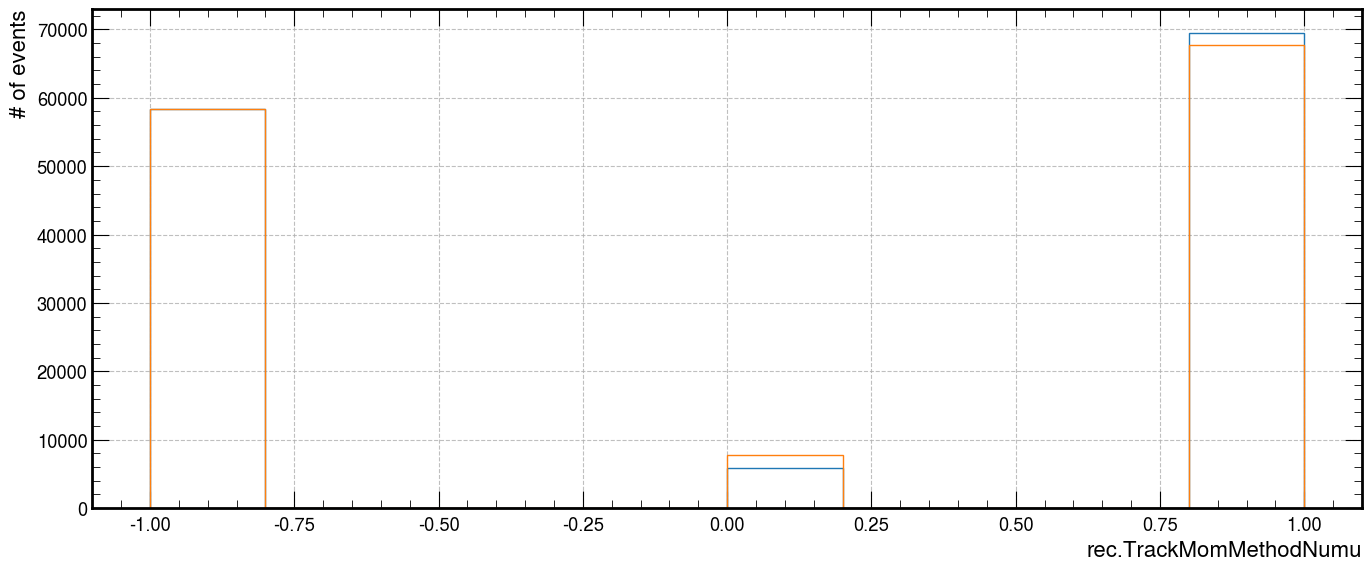

In [18]:
def make_plot(ax:plt.Axes, val:str, df:pl.DataFrame):
    df = df.filter(pl.col('rec.isCC') != 1)
    ax.hist(df[val], histtype='step')
    ax.set_xlabel(val)
    ax.set_ylabel('# of events')
fig, axs = plt.subplots(1,1,figsize=(14,6))
make_plot(axs, 'rec.LongestTrackContNumu', dfnew)
make_plot(axs, 'rec.TrackMomMethodNumu', dfnew)
Emu.filter(pl.col('rec.LongestTrackContNumu')==1)['rec.TrackMomMethodNumu'].describe()
# make_plot(axs[1], 'rec.TrackMomMethodNumu', df)

# df.select(
#     pl.col('rec.')
# )

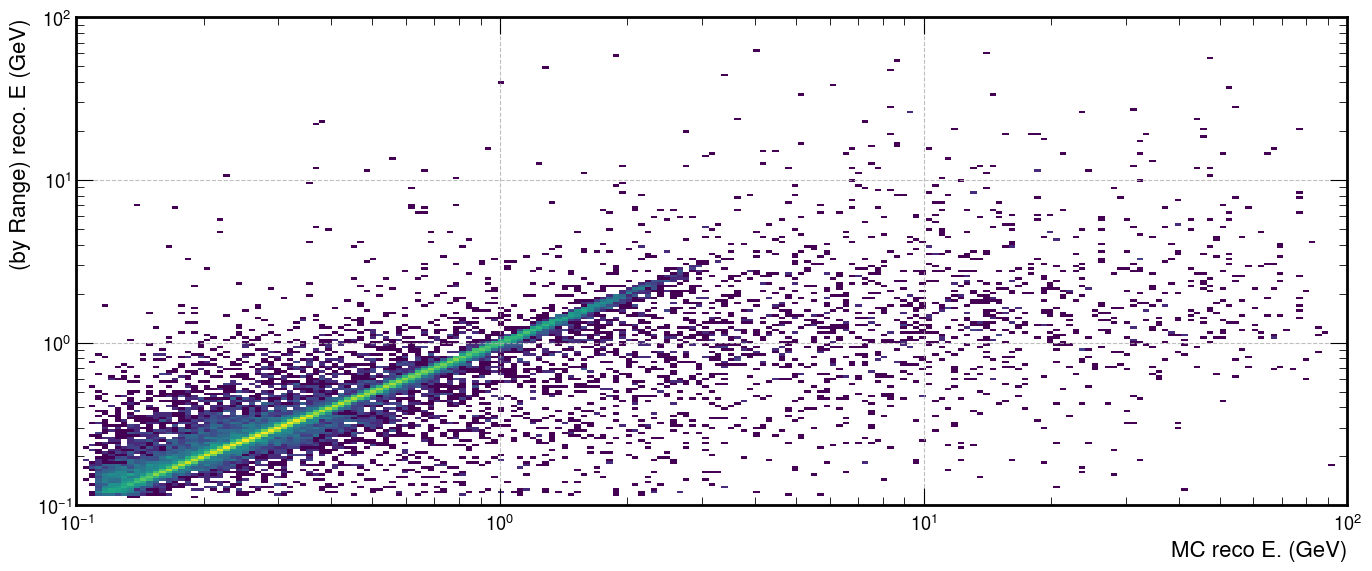

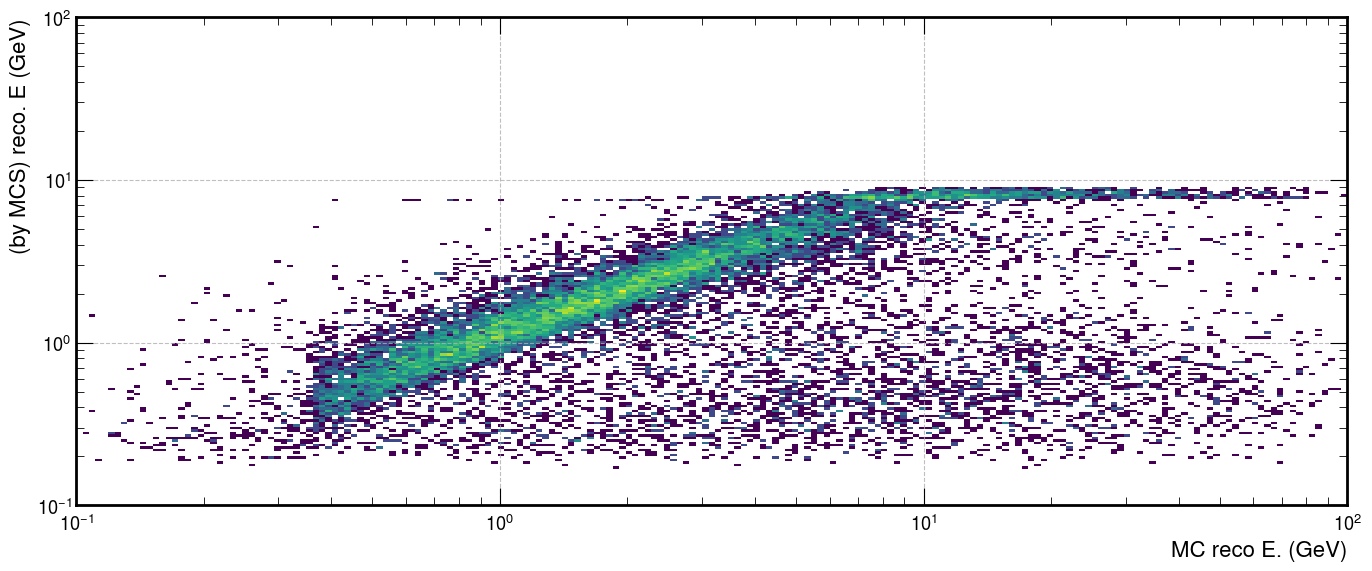

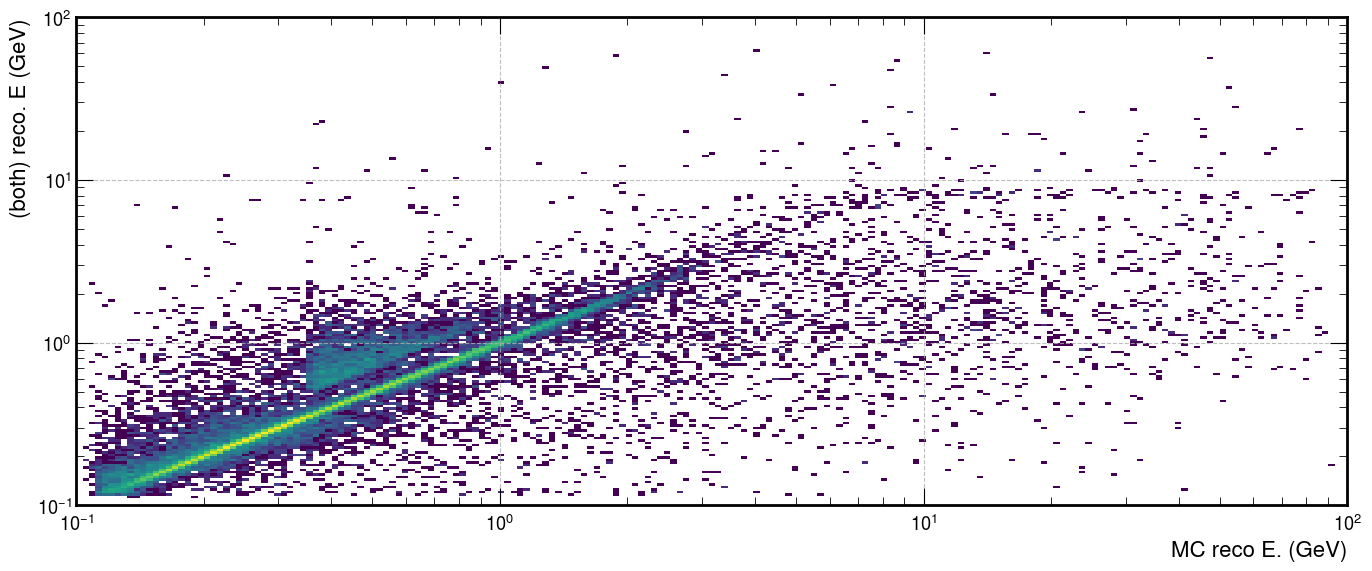

In [34]:
E = checkEnergy(df)
Enew = dfnew
Emu = E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14)).filter(pl.col('rec.LongestTrackContNumu') != -1)
Enew = Enew.filter(flavour(14)).filter(pl.col('rec.isCC')==1)#.filter(pl.col('rec.LongestTrackContNumu') != -1)
# plt.plot(df.filter(pl.col('rec.nuPDG')==14).filter(pl.col('rec.isCC')==1)['rec.RecoHadEnNumu'])
def plot_mu_vs_mu(Emu:pl.DataFrame, label):
    fig = plt.figure(figsize=(14,6))
    binsx = np.logspace(-1,2,200)
    if 'LepE_h' in Emu.columns:
        plt.hist2d(Emu['rec.LepE'],Emu['LepE_h'], bins=(binsx,binsx), norm=LogNorm());
    else:
        plt.hist2d(Emu['rec.LepE'],Emu['rec.RecoLepEnNumu'], bins=(binsx,binsx), norm=LogNorm());
    plt.xscale('log')
    plt.xlabel('MC reco E. (GeV)')
    plt.ylabel(f'{label} reco. E (GeV)')
    plt.yscale('log')

# plot_mu_vs_mu(Emu.filter(pl.col('rec.LongestTrackContNumu')==1), label='(old)')
plot_mu_vs_mu(Enew.filter(pl.col('rec.LongestTrackContNumu')==1).filter(pl.col('rec.TrackMomMethodNumu')==1), label='(by Range)')
plot_mu_vs_mu(Enew.filter(pl.col('rec.LongestTrackContNumu')==0).filter(pl.col('rec.TrackMomMethodNumu')==0), label='(by MCS)')
plot_mu_vs_mu(Enew.filter(pl.col('rec.LongestTrackContNumu')==1).filter(pl.col('rec.TrackMomMethodNumu')!=-1), label='(both)')

rec.subrun,rec.event,rec.Ev,rec.LepE,rec.RecoLepEnNumu
i32,i32,f32,f32,f32
9,10,0.942196,0.695131,0.863745
9,14,0.927076,0.407668,0.604028
11,16,0.437398,0.364893,0.517648
12,11,0.656826,0.437881,0.826653
17,4,1.5608,0.582466,0.831385
20,8,1.628478,0.415241,0.850677
21,10,1.493975,0.490047,0.823169
27,1,0.837116,0.532146,1.067549
31,17,1.333192,0.289056,0.735869


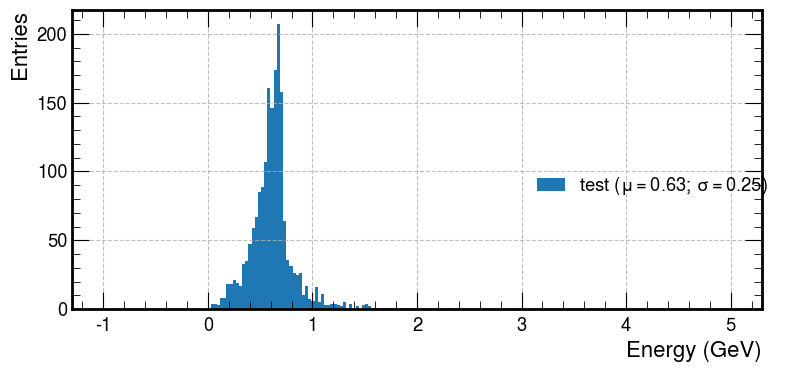

In [36]:

test = Enew.filter(pl.col('rec.LongestTrackContNumu')==1).filter(pl.col('rec.TrackMomMethodNumu')==0).filter(pl.col('rec.LepE')<3).select(['rec.subrun','rec.event','rec.Ev','rec.LepE', 'rec.RecoLepEnNumu']).sort(['rec.subrun','rec.event'])
test.select(
    pl.col('rec.LepE')/pl.col('rec.RecoLepEnNumu')
)
fig, ax = plt.subplots(1,1, figsize=(8,4))
fig = hstat(data=test.select(
    pl.col('rec.LepE')/pl.col('rec.RecoLepEnNumu')
), ax=ax,
bins=np.linspace(-1,5,200),
label='test'
);
fig.legend(loc='center right')
ax = fig.gca()
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Entries')
test

rec.Ev_reco
f32
null
null
null
null
null
null
null
null
null
